In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import *
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.applications import ResNet50V2


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Dataset/FER2013/FER2013.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
# define a  function to caculate the number of each emotion classes
train_dir = "/content/train"
test_dir = "/content/test"
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


**Explanation:** The number of happy faces is about 17 times tha disgust faces in test data set.

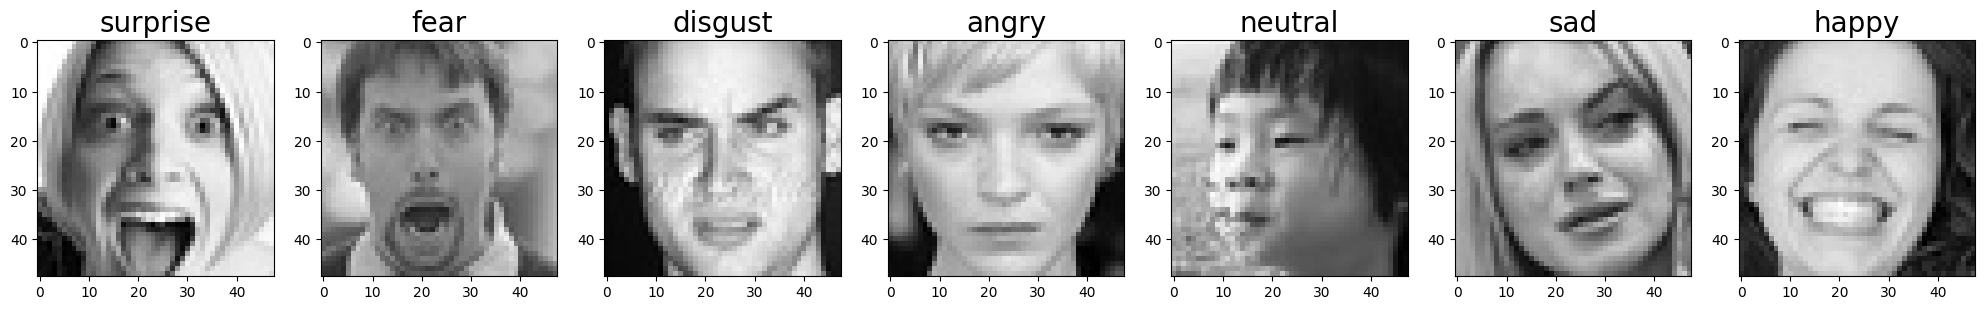

In [ ]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL +'/'+ directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

**Explanation:** Show how the images in the data set look like.

In [ ]:
img_shape = 48
batch_size = 64
train_data_path = "/content/train/"
test_data_path = "/content/test/"


In [ ]:
#using data generators to generate batches of images
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### **CNN Model**

In [ ]:
CNN_Model =model = Sequential()

    #CNN1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

    #CNN2
model.add(Conv2D(64, (3,3), activation='relu', ))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

    #CNN3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))


    #Output
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

### **Specifying CNN Callbacks**

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

### **CNN Training**

In [ ]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=20, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 978s 2s/step - loss: 2.0391 - accuracy: 0.2182 - val_loss: 1.9865 - val_accuracy: 0.2486 - lr: 0.0010
Epoch 2/20
448/448 [==============================] - 964s 2s/step - loss: 1.7463 - accuracy: 0.2925 - val_loss: 1.5885 - val_accuracy: 0.3641 - lr: 0.0010
Epoch 3/20
448/448 [==============================] - 925s 2s/step - loss: 1.6122 - accuracy: 0.3631 - val_loss: 1.6917 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 4/20
448/448 [==============================] - 963s 2s/step - loss: 1.4917 - accuracy: 0.4191 - val_loss: 1.3606 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 5/20
448/448 [==============================] - 940s 2s/step - loss: 1.4184 - accuracy: 0.4584 - val_loss: 1.2978 - val_accuracy: 0.4973 - lr: 0.0010
Epoch 6/20
448/448 [==============================] - 971s 2s/step - loss: 1.3638 - accuracy: 0.4809 - val_loss: 1.2521 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 7/20
448/448 [==============================] - 933s 2s/st

### **Evaluating CNN Model**

In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

###   **NN Confusion Matrix**

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [ ]:
#get the relationship between classes name and numbers
test_data.class_indices

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

### **ResNet50V2 Model**

In [ ]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = "/content/train/"
test_data_path = "/content/test/"

In [ ]:
#load data again
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

### **Fine-Tuning ResNet50V2**

In [ ]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

### **Customed Output Layer**

In [ ]:
ResNet50V2_Model = model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

### **ResNet Training**

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

### **Visualising ResNet Loss and Accuracy**

In [ ]:
plot_curves(ResNet50V2_history)

### **Evaluating ResNet50V2**

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

### **ResNet Confusion Matrix**

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

In [ ]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

### **5Shuffling Test Data**

In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(48,48),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

### **CNN Predictions**

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

**Explanation:** The CNN model have a good performance in predicting new image.

### **ResNet50V2 Predictions**

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

## **Save Models**

In [ ]:
CNN_Model.save("CNN_Model.h5")

ResNet50V2_Model.save("ResNet50V2_Model.h5")